### Preprocessing Data

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_20newsgroups

# load both training and testing splits for performin the unsupervised clustering 
raw_dataset = fetch_20newsgroups(subset='all', shuffle=False)
print(raw_dataset.data[0])

From: cubbie@garnet.berkeley.edu (                               )
Subject: Re: Cubs behind Marlins? How?
Article-I.D.: agate.1pt592$f9a
Organization: University of California, Berkeley
Lines: 12
NNTP-Posting-Host: garnet.berkeley.edu


gajarsky@pilot.njin.net writes:

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

       This season so far, Morgan and Guzman helped to lead the Cubs
       at top in ERA, even better than THE rotation at Atlanta.
       Cubs ERA at 0.056 while Braves at 0.059. We know it is early
       in the season, we Cubs fans have learned how to enjoy the
       short triumph while it is still there.



In [5]:
# remove the headers, footers, and quotes from the documents.
dataset = fetch_20newsgroups(subset='all', shuffle=False, remove=('headers', 'footers', 'quotes'))
print(dataset.data[0])


morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)


In [6]:
corpus = dataset.data # save as the raw docs
gnd_labels = dataset.target # labels for clustering evaluation or supervised tasks
print(len(corpus), len(gnd_labels))
print(type(corpus), type(gnd_labels))
print(gnd_labels)
print(dataset.target_names)

18846 18846
<class 'list'> <class 'numpy.ndarray'>
[ 9  4 11 ...  4  6  7]
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


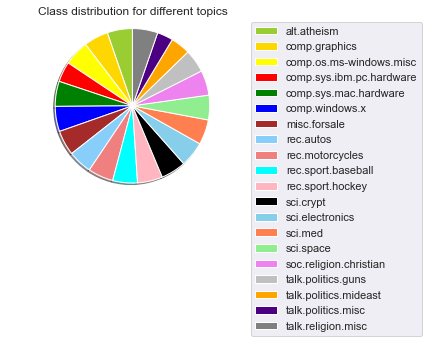

In [99]:
# Visualizing class Distribution
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
# Counter(labels)
label_20, values = zip(*Counter(gnd_labels).items())
indexes = np.arange(len(label_20)) 

# plot the labels
label_20 = dataset.target_names
val = values
colors = ['yellowgreen', 'gold', 'yellow', 'red', 'green', 'blue', 'brown', 'lightskyblue', 'lightcoral','cyan','lightpink','black', 'skyblue', 'coral','lightgreen', 'violet', 'silver', 'orange', 'indigo', 'gray']
patches, texts = plt.pie(val,colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
# plt.legend(patches, labels, loc="best")
plt.legend(patches, label_20, bbox_to_anchor=(0.95,1.025), loc="upper left")
plt.axis('equal')
plt.tight_layout()
plt.title('Class distribution for different topics')
plt.show()

In [8]:
# Let's show the first 2 documents
for i in range(2):
    doc = corpus[i]
    category = dataset.target_names[gnd_labels[i]]
    print("The {}-th sent of {}: {}".format(i+1, category, doc))
    print("==================================================\n")

The 1-th sent of rec.sport.baseball: 
morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

The 2-th sent of comp.sys.mac.hardware: Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substituted one _with_ ethernet.
He wanted to know if that would be "alright with me"!!!  They must
be backlogged on Centri w/out ethernet so they're just shipping them
with!  

	Anyway, I'm very happy with the 610 with a few exceptions.  
Being nosy, I decided to open it up _before_ powering it on for the first
time.  The SCSI cable to the hard drive was only partially connected
(must have come loose in shipping).  No big deal, but I would have been
pissed if I tried to boot it and it wou

### Tokenization

In [6]:
!pip install stop_words

In [9]:
# perform more Pre-processing steps
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from pprint import pprint

def pre_processing(docs):
    tokenizer = RegexpTokenizer(r"\w+(?:[-'+]\w+)*|\w+")
    en_stop = get_stop_words('en')
    for doc in docs:
        raw_text = doc.lower()
        # tokenization
        tokens_text = tokenizer.tokenize(raw_text)
        # remove stopwords
        stopped_tokens_text = [i for i in tokens_text if not i in en_stop]
        # remoce digis and one-charcter word
        doc = [token for token in stopped_tokens_text if not token.isnumeric()]
        doc = [token for token in stopped_tokens_text if len(token) > 1]
        # you could always add some new preprocessing here
        yield doc

### Build Vocab

In [10]:
# Preprocess all the documents in the corpus
Vocab_v1 = list(pre_processing(corpus))

In [11]:
# verify length of the clean corpus and print a sample clean tokenized document
print(len(Vocab_v1))
print(Vocab_v1[0])

18846
['morgan', 'guzman', 'will', "era's", 'run', 'higher', 'last', 'year', 'cubs', 'will', 'idiots', 'pitch', 'harkey', 'much', 'hibbard', 'castillo', 'good', 'think', 'stud', 'pitcher']


### Word2Vec representation

In [12]:
from gensim.models import word2vec
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle
import time
import pandas as pd

In [13]:
# train the Word2Vec model on the cleaned sentences
start = time.time()
# Set values for various parameters
# Dimensionality of the hidden layer representation
num_features = 100
# Minimum word count to keep a word in the vocabulary    
min_word_count = 20
# Context window size (on each side)
context = 5
# Downsample setting for frequent words                                                             
downsampling = 1e-3  

# Initialize and train the model. 
print("Training model...");
w2v_model = word2vec.Word2Vec(Vocab_v1, vector_size=num_features, min_count = min_word_count, window = context, sample = downsampling)
# calling init_sims to make the model more memory efficient by normalizing the vectors in-place.
w2v_model.init_sims(replace=True);
# Save the model
model_name = "model_full_20newsGroup";
w2v_model.save(model_name);
print('Total time: ' + str((time.time() - start)) + ' secs')

Training model...
Total time: 9.762474298477173 secs


In [14]:
# Obtain the Word Vectors for each word in the vocab, stored in a variable called ‘syn0’
word_vectors = w2v_model.wv.vectors;
print(word_vectors[0].shape)
# print word vector for the first word: 100-element vector with values
word_vectors[0]

(100,)


array([-0.06605195, -0.07722677,  0.04269628,  0.0229256 , -0.11085553,
        0.01106036,  0.0325462 , -0.05932026, -0.04719164, -0.03844238,
        0.10132309,  0.1002269 , -0.16275775,  0.0395636 ,  0.06339975,
        0.09369136, -0.02365172,  0.11626773,  0.0411986 , -0.10255773,
        0.0853534 ,  0.00901844,  0.17035018,  0.08322218,  0.13219829,
       -0.0066514 , -0.05253134,  0.13642864,  0.01509511,  0.00852278,
       -0.10020445, -0.06049728,  0.29500678, -0.17631857,  0.01306978,
       -0.03896719,  0.02283975, -0.00867417,  0.12821   ,  0.08412805,
       -0.10678709, -0.05954872, -0.01668298,  0.12022087,  0.02044605,
       -0.1161731 ,  0.04082828,  0.12379812,  0.06187574,  0.05370968,
        0.02544187,  0.12368129,  0.00626367,  0.13411354,  0.2197605 ,
       -0.0598956 ,  0.11910451, -0.09537128,  0.07580575,  0.03536361,
       -0.06521724, -0.00519337,  0.12155099, -0.05736648, -0.05738404,
       -0.00433941,  0.13641125,  0.26476863,  0.17583692,  0.00

In [15]:
# print length of word vectors
len(word_vectors)

11595

In [16]:
# cluster the words using KMeans
num_clusters = 20
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
clusters = kmeans_clustering.fit_predict(word_vectors)
centers = kmeans_clustering.cluster_centers_
centroid_map = dict(zip(w2v_model.wv.index_to_key, clusters))

In [17]:
# initialize a KDTree on the word vectors, and query it for the Top K words on each cluster center.
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df

In [18]:
# get the top words and print the first 2 in each cluster:
top_words = get_top_words(w2v_model.wv.index_to_key, 5000, centers, word_vectors);
top_words[:2]

,Cluster #0,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11,Cluster #12,Cluster #13,Cluster #14,Cluster #15,Cluster #16,Cluster #17,Cluster #18,Cluster #19
1,anymore,r_,initialization,engaging,preached,nyr,establishment,mechanisms,sponsored,prisoners,x386,helmets,thin,stayed,33mhz,faqs,steven,twins,emotional,isolation
2,bother,m7,allocate,merits,pharisees,176,involvement,procedures,federation,invaded,interpreter,worn,drops,clothes,25mhz,moderated,gibson,canadiens,analogy,projection


In [19]:
# Create a word cloud with the words of a cluster and print and save them.
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num)]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

In [18]:
!pip install wordcloud

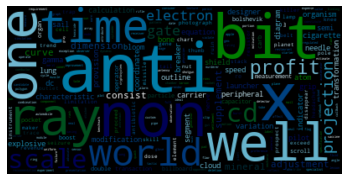

In [20]:
# call on each cluster, and pass in a different color scheme in each iteration to distinguish them.
from wordcloud import WordCloud 
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])
for i in range(0, 20):
    col = next(cmaps)
    display_cloud(i, col)

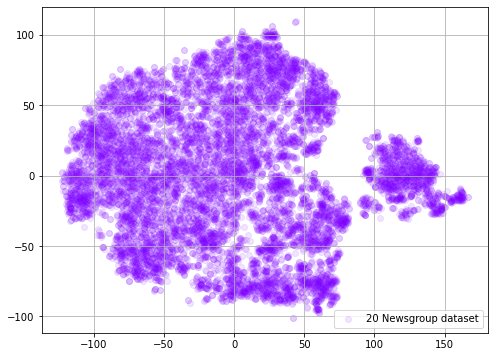

In [21]:
# Visualize learned word embedding space using t-SNE1
from sklearn.manifold import TSNE
import matplotlib.cm as cm
words_20ng = []
embeddings_20ng = []
for word in list(w2v_model.wv.key_to_index):
    embeddings_20ng.append(w2v_model.wv[word])
    words_20ng.append(word)
    
tsne_w2v_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_w2v_2d = tsne_w2v_2d.fit_transform(embeddings_20ng)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(8, 6))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("tsne_plot.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('20 Newsgroup dataset', embeddings_w2v_2d, a=0.1)

### Doc2Vec representation method

In [22]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn import utils
import csv
from tqdm import tqdm

In [23]:
# prepare data for training the doc2vec model
tagged_data = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(Vocab_v1)]

In [24]:
max_epochs = 20
vec_size = 50
alpha = 0.025
# Train the model
d2v_model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm =1)
d2v_model.build_vocab(tagged_data)
# dm=1 means ‘distributed memory’ (PV-DM) and dm =0 means ‘distributed bag of words’ (PV-DBOW).
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 516.7908926010132 secs


In [25]:
d2v_model.train(tagged_data,
                total_examples=d2v_model.corpus_count,
                epochs=max_epochs)
    # decrease the learning rate
d2v_model.alpha -= 0.0002
    # fix the learning rate, no decay
d2v_model.min_alpha = d2v_model.alpha

d2v_model.save("d2v.model")
print("Model Saved")

Model Saved


In [27]:
# Using these document vectors, we will perform clustering
from sklearn.cluster import KMeans
import statistics
from sklearn.metrics import normalized_mutual_info_score as NMI
kmeans_d2v = KMeans(n_clusters=20) 
idx_d2v, nmis_d2v = [], []
for i in range(5):
    # run K-means
    kmeans_d2v.fit_predict(d2v_model.dv.vectors)
    # idx.append(the obtained clustering labels)
    idx_d2v.append(kmeans_d2v.labels_)
    # nmi.append(nmi_score(gnd, clustering label))
    nmis_d2v.append(NMI(gnd_labels, kmeans_d2v.labels_))
    
# report mean and std values of nmis
mean = sum(nmis_d2v) / len(nmis_d2v) 
print("NMI mean for Doc2Vec K-means: %f" %mean)
variance = sum([((x - mean) ** 2) for x in nmis_d2v]) / len(nmis_d2v) 
std = variance ** 0.5
# Printing result 
print("NMI std for Doc2Vec K-means: " + str(std))

NMI mean for Doc2Vec K-means: 0.194951
NMI std for Doc2Vec K-means: 0.012982298857520832


### Scatter plot for Kmeans clustering with best NMI score

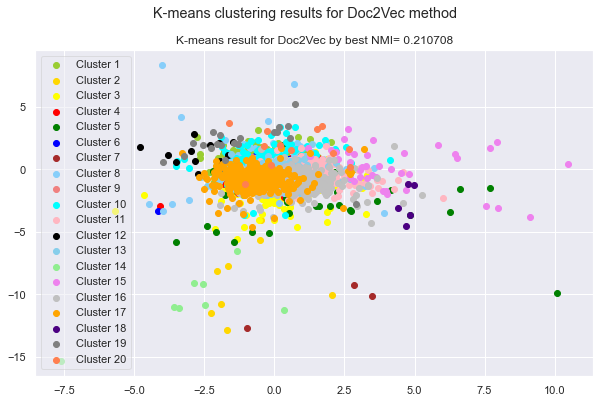

In [28]:
# Scatter plot for Kmeans clustering with best NMI score
import seaborn as sns
sns.set_theme()
semantic_labels = dataset.target_names
clustering_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12',
                     'Cluster 13', 'Cluster 14', 'Cluster 15', 'Cluster 16', 'Cluster 17', 'Cluster 18', 'Cluster 19', 'Cluster 20']

# TODO: 
# find the best clustering labels by NMI, termed as bst_idx
bst_idx = idx_d2v[nmis_d2v.index(max(nmis_d2v))]

# scatter plot the data samples upon the clustering labels and bst_idx
fig, (ax2) = plt.subplots(1, 1, figsize=(10,6))
fig.suptitle('K-means clustering results for Doc2Vec method')
colors = ['yellowgreen', 'gold', 'yellow', 'red', 'green', 'blue', 'brown', 'lightskyblue', 'lightcoral','cyan','lightpink','black', 'skyblue','lightgreen', 'violet', 'silver', 'orange', 'indigo', 'gray', 'coral']
# fill out the NMI values in the title
ax2.set_title('K-means result for Doc2Vec by best NMI= %f' %max(nmis_d2v))

for color, i in zip(colors, range(0,20)):
    ax2.scatter(d2v_model.dv.vectors[bst_idx == i,0], d2v_model.dv.vectors[bst_idx ==i, 1], color=color, label=clustering_labels[i])
    # ax2.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')
    
# ax1.legend(fancybox=True, framealpha=0.5)
# add legends for ax2 
ax2.legend(fancybox=True, framealpha=0.5)

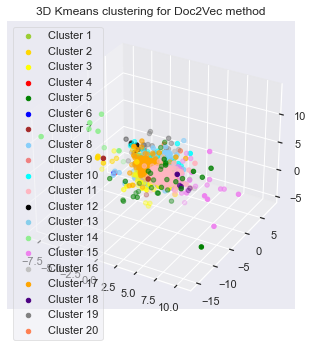

In [29]:
# Viewing Kmeans clustering in 3D
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
ax=Axes3D(fig)
x= d2v_model.dv.vectors
for color, i in zip(colors, range(0,20)):
    ax.scatter(x[bst_idx == i,0],x[bst_idx == i,1],x[bst_idx == i,2],color=color, label=clustering_labels[i])
# add legends for ax
ax.legend(fancybox=True, framealpha=0.5)
plt.title("3D Kmeans clustering for Doc2Vec method")
plt.show()


### Different Clustering Algorithm 

NMI score: 0.132590


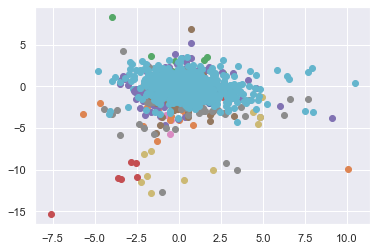

In [30]:
# gaussian Mixture clustering
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.mixture import GaussianMixture

# define the model
gm = GaussianMixture(n_components=20, tol=0.0001, max_iter=200)
# fit the model
x= d2v_model.dv.vectors
gm.fit(x)
# assign a cluster to each example
yhat_gm = gm.predict(x)
# print NMI score
print("NMI score: %f" %(NMI(gnd_labels, yhat_gm)))

# retrieve unique clusters
clusters = unique(yhat_gm)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat_gm == cluster)
    # create scatter of these samples
    pyplot.scatter(x[row_ix, 0], x[row_ix, 1])
# show the plot
pyplot.show()

In [50]:
!pip install fuzzy-c-means

  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.7.4
    Uninstalling pydantic-1.7.4:
      Successfully uninstalled pydantic-1.7.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.0.6 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.9.0 which is incompatible.
spacy 3.0.6 requires pydantic<1.8.0,>=1.7.1, but you have pydantic 1.9.0 which is incompatible.


NMI score: 0.013374


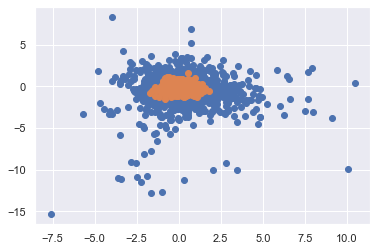

In [31]:
from fcmeans import FCM
# create an instance of fuzzy clustering model
fcm = FCM(n_clusters=20, m=2)
# fit the model
fcm.fit(x)

# fuzzy cluter model centers
fcm_centers = fcm.centers
# predict cluster labels
fcm_labels = fcm.predict(x)
# print NMI score
print("NMI score: %f" %NMI(gnd_labels, fcm_labels))

# retrieve unique clusters
clusters = unique(fcm_labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(fcm_labels == cluster)
    # create scatter of these samples
    pyplot.scatter(x[row_ix, 0], x[row_ix, 1])
# show the plot
pyplot.show()

In [53]:
from sklearn.cluster import MiniBatchKMeans
from statistics import mean
# define the model and fit it
mkm = MiniBatchKMeans(n_clusters=20).partial_fit(x)
nmi_mkm = []
print(x)
for i in range(5):
  # assign a cluster to each example
  yhat_mkm = mkm.predict(x)
  # save NMI score for each run
  nmi_mkm.append(NMI(gnd_labels, yhat_mkm))

print("NMI mean: %f" %mean(nmi_mkm))
print("NMI max: %f" %max(nmi_mkm))

[[-0.12709872 -0.17389822  0.04545733 ...  0.03793394 -0.11178493
   0.3736402 ]
 [-0.53248894 -0.76611125  0.27789745 ...  0.43770286 -0.77879
   0.70040226]
 [ 0.93755376 -1.3858413   1.3654858  ...  2.9400227  -2.9405723
  -1.0137017 ]
 ...
 [-0.1081997   0.1726859   0.16571884 ... -0.15302202 -0.14799662
   0.01120442]
 [-0.3215767  -1.0916672   0.8312973  ...  0.32431996 -1.393107
   0.878873  ]
 [-0.08373744 -0.2592457  -0.01521907 ...  0.05014437 -0.18523984
   0.02204518]]
NMI mean: 0.148637
NMI max: 0.148637


### BOW Representations

In [39]:
from copy import deepcopy
# Converting words in list to plain text
Vocab_v3 = deepcopy(Vocab_v1)
from itertools import chain
for i in range(0, len(Vocab_v3)):
    data = Vocab_v3[i]
    Vocab_v3[i] = " ".join(str(i) for i in chain(data))

In [40]:
# Generate the bow vectors for the corpus
from sklearn.feature_extraction.text import CountVectorizer 
# Initialize an instance of count Vectorizer
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(Vocab_v3)

In [41]:
# print shape of the sparse matrix
print(X_counts.shape)
# normalise existing X_counts
from sklearn import preprocessing
X_Norm = preprocessing.normalize(X_counts)

(18846, 134383)


In [42]:
# transforming dataset matrix using SVD
from sklearn.decomposition import TruncatedSVD
# Getting no of components
no_components = 1000
print("Number of components: %d" %(no_components))

#Fitting the SVD class
trun_svd1 =  TruncatedSVD(n_components = no_components)
X_transformed = trun_svd1.fit_transform(X_Norm)

# Printing the transformed matrix shape
print("Transformed Matrix:")
print(X_transformed.shape)

Number of components: 1000
Transformed Matrix:
(18846, 1000)


In [43]:
# Using this csr sparse matrix, we will perform clustering
from sklearn.cluster import KMeans
import statistics
from sklearn.metrics import normalized_mutual_info_score as NMI
kmeans_bow = KMeans(n_clusters=20) 
idx_bow, nmis_bow = [], []
for i in range(3):
    # run K-means
    kmeans_bow.fit_predict(X_transformed)
    # idx.append(the obtained clustering labels)
    idx_bow.append(kmeans_bow.labels_)
    # nmi.append(nmi_score(gnd, clustering label))
    nmis_bow.append(NMI(gnd_labels, kmeans_bow.labels_))
    
# report mean and std values of nmis
mean = sum(nmis_bow) / len(nmis_bow) 
print("NMI mean for K-means: %f" %mean)
variance = sum([((x - mean) ** 2) for x in nmis_bow]) / len(nmis_bow) 
std = variance ** 0.5
# Printing result 
print("NMI std for BoW K-means: " + str(std))

NMI mean for K-means: 0.124968
NMI std for BoW K-means: 0.013886413954781565


### Supervised classification using SVM

In [55]:
# Splitting the dataset(Doc2Vec doc representation)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(d2v_model.dv.vectors, gnd_labels, test_size = 0.30, random_state = 42)

In [56]:
print(X_train.shape)
print(X_test.shape)

(13192, 50)
(5654, 50)


In [57]:
# Tuning SVM model hyperparameters
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_score, GridSearchCV 
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.01, 0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['linear', 'rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose=2) 
  
# fitting the model for grid search 
grid.fit(X_train, Y_train) 

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   7.7s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   8.9s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   7.8s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   7.1s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   6.8s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  16.5s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  16.6s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  17.1s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  16.8s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  16.7s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   6.8s
[CV] END ...................C=0.01, gamma=0.1, 

[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   4.9s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   4.7s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   4.6s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   4.6s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  10.4s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  10.6s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  10.4s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  10.6s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  10.4s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   4.7s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   4.6s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   4.5s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [58]:
# printing best parameter after tuning 
print(grid.best_params_) 
  
# print the model after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, gamma=0.01)


In [59]:
from sklearn.metrics import classification_report
# rerunning the predictions and generating the classification on this grid object
grid_pred = grid.predict(X_test) 
  
# print classification report 
print(classification_report(Y_test, grid_pred)) 

              precision    recall  f1-score   support

           0       0.31      0.41      0.36       238
           1       0.53      0.60      0.56       289
           2       0.49      0.52      0.51       308
           3       0.48      0.45      0.47       273
           4       0.44      0.42      0.43       289
           5       0.78      0.60      0.68       317
           6       0.61      0.63      0.62       281
           7       0.51      0.57      0.54       282
           8       0.29      0.62      0.40       316
           9       0.58      0.67      0.63       297
          10       0.78      0.60      0.68       298
          11       0.74      0.63      0.68       282
          12       0.60      0.44      0.51       320
          13       0.81      0.72      0.76       289
          14       0.66      0.69      0.68       278
          15       0.68      0.67      0.67       327
          16       0.58      0.57      0.58       268
          17       0.74    

In [60]:
# perform cross validation using recommended parameter values
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm
from numpy import mean
from numpy import std

# define the model
clf_svm = svm.SVC(kernel='rbf', C=1, gamma= 0.01) 
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf_svm, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.525 (0.014)


In [61]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
# define the model
clf_svm = svm.SVC(kernel='rbf', C=1, gamma= 0.01) 
#Train the model using the training set
clf_svm.fit(X_train, Y_train)
#Predict the response for test dataset
svm_pred = clf_svm.predict(X_test)
# print the accuracy and f1-score
accuracy_val = accuracy_score(Y_test, svm_pred)
f1_score_val = f1_score(Y_test, svm_pred, average = 'weighted')
print('\nAccuracy  = ', accuracy_val)
print('F1 score  = ', f1_score_val) 


Accuracy  =  0.5272373540856031
F1 score  =  0.5348667027342783


In [62]:
# define the mean square error function
def mse(y_hat, y):
    return ((y_hat-y)**2).sum()/len(y)

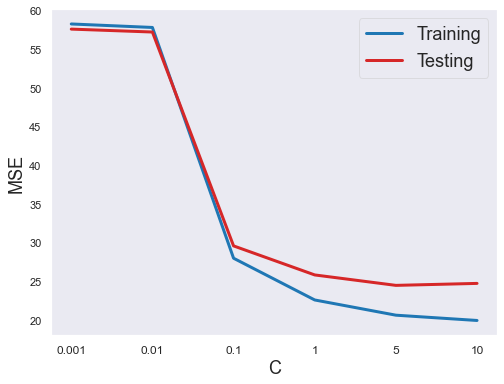

In [63]:
# verifying training and testing error over different values of C
C_val = [0.001, 0.01, 0.1, 1, 5, 10]
loss_trns = []
loss_vals = []
for c_val in C_val:
    # instantiate a SVM model with a given C_val
    model = svm.SVC(kernel='rbf', C=c_val, gamma= 0.01) 
    # training the model 
    model.fit(X_train, Y_train)
    loss_trns.append(mse(model.predict(X_train), Y_train))
    # loss_vals.append(?)
    loss_vals.append(mse(model.predict(X_test), Y_test))

fig, ax = plt.subplots(figsize=(8,6))
plt.grid(which='both',axis='both', color='grey',linestyle=':')

# plot the training and testing loss
# plt.plot(training MSE)
plt.plot(np.arange(len(C_val)), loss_trns, label='Training', color='tab:blue', linewidth=3)
# plt.plot(testing MSE)
plt.plot(np.arange(len(C_val)), loss_vals, label='Testing', color='tab:red', linewidth=3)

plt.ylabel('MSE', fontsize=18)
plt.xlabel('C', fontsize=18)
plt.xticks(np.arange(len(C_val)), C_val, fontsize=12)
plt.legend(fancybox=True, framealpha=0.5, fontsize=18)
plt.show()

### Extracting Top 2k Word

In [64]:
# Let's get a new corpus by using tokenization method above
corpus1 = list(pre_processing(corpus[:]))
print(len(corpus1))

# build the vocab
freqs = defaultdict(int)
for doc in corpus1:
    for w in doc:
        freqs[w] += 1
print(len(freqs))
vocab = [w for w in freqs if freqs[w]>1]
print(len(vocab))

18846
156073
64117


In [65]:
# sort the words by frequency
import pandas as pd
df = pd.DataFrame()
df[0] = freqs.keys()
df[1] = freqs.values()
# print top 5 rows of df
print(df.head())

        0      1
0  morgan     43
1  guzman      8
2    will  10526
3   era's      4
4     run   1499


In [66]:
# Extract top 2k words with highest frequency
df.sort_values(1, inplace=True, ascending=False)
top_2k_words = df[0][:2000]
top_2k_words = top_2k_words.to_list()

In [69]:
# define a function to keep only top 2k words in the documents
def keep_top2k_words(words):
    #keep only top 2k words
    k_words = []
    for word in words:
        if word in top_2k_words:
            k_words.append(word)
    return k_words

In [70]:
# Create list of words for each document: keep only freq words
from copy import deepcopy
Vocab_v = deepcopy(corpus1)
for i in range(len(Vocab_v)):
    Vocab_v[i] = keep_top2k_words(Vocab_v[i])

In [71]:
# Documents containing only high frequency terms
len(Vocab_v)

18846

### BOW for 2k words 

In [72]:
# collect all of the terms in Vocab_v worlist
lexicon = corpora.Dictionary(Vocab_v)

In [73]:
# get mapping of each term into a numeric id
lexicon.token2id

{'good': 0,
 'higher': 1,
 'last': 2,
 'much': 3,
 'run': 4,
 'think': 5,
 'will': 6,
 'year': 7,
 'also': 8,
 'anyway': 9,
 'apple': 10,
 'big': 11,
 'cable': 12,
 'come': 13,
 'computer': 14,
 'connected': 15,
 'control': 16,
 'deal': 17,
 'dealer': 18,
 'decided': 19,
 'drive': 20,
 'ethernet': 21,
 'fast': 22,
 'feature': 23,
 'first': 24,
 'functions': 25,
 'get': 26,
 'got': 27,
 'great': 28,
 'happy': 29,
 'hard': 30,
 'heard': 31,
 'high': 32,
 'just': 33,
 'keyboard': 34,
 'know': 35,
 'lack': 36,
 'location': 37,
 'machine': 38,
 'made': 39,
 'mentioned': 40,
 'might': 41,
 'must': 42,
 'oh': 43,
 'one': 44,
 'open': 45,
 'order': 46,
 'others': 47,
 'price': 48,
 'saw': 49,
 'screen': 50,
 'scsi': 51,
 'seems': 52,
 'seen': 53,
 'shipping': 54,
 'store': 55,
 'time': 56,
 'took': 57,
 'tried': 58,
 'try': 59,
 'two': 60,
 'wanted': 61,
 'way': 62,
 'weeks': 63,
 'well': 64,
 'without': 65,
 'yesterday': 66,
 '10': 67,
 '11': 68,
 '12': 69,
 '130': 70,
 '14': 71,
 '15': 72,
 

In [74]:
# Create Bag of Words for 2k high frequency words
bow_2k = []
for t in Vocab_v:
    bow_2k.append(lexicon.doc2bow(t))
# print bow_2k 

In [75]:
from gensim import corpora, matutils, models, similarities
from gensim.similarities.docsim import MatrixSimilarity
# Create term frequency matrix
tf_array_2k = matutils.corpus2dense(bow_2k, num_terms=len(lexicon.token2id))
tf_array_2k

array([[1., 0., 2., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [76]:
# create term frequency sparse array
tf_sparse_array = matutils.corpus2csc(bow_2k)
tf_sparse_array

<2000x18846 sparse matrix of type '<class 'numpy.float64'>'
	with 706104 stored elements in Compressed Sparse Column format>

In [77]:
# Calculating similarity
matsim = MatrixSimilarity(bow_2k, num_features=len(lexicon))
matsim[bow_2k[1]]

array([0.08155908, 1.0000001 , 0.0618648 , ..., 0.01803339, 0.08732635,
       0.09639254], dtype=float32)

In [78]:
np.round(matsim[bow_2k], 3)

array([[1.   , 0.082, 0.011, ..., 0.06 , 0.053, 0.   ],
       [0.082, 1.   , 0.062, ..., 0.018, 0.087, 0.096],
       [0.011, 0.062, 1.   , ..., 0.028, 0.034, 0.005],
       ...,
       [0.06 , 0.018, 0.028, ..., 1.   , 0.   , 0.   ],
       [0.053, 0.087, 0.034, ..., 0.   , 1.   , 0.047],
       [0.   , 0.096, 0.005, ..., 0.   , 0.047, 1.   ]], dtype=float32)

In [80]:
# perform kmeans clustering
from sklearn.cluster import KMeans
km_bow_2k = KMeans(n_clusters=20)
similarity_matrix = matsim[bow_2k]
km_bow_2k.fit_predict(similarity_matrix)

array([13, 16,  6, ...,  8,  0,  4])

In [81]:
# print NMI score for BoW top 2k words model
from sklearn.metrics import normalized_mutual_info_score as NMI
NMI(gnd_labels, km_bow_2k.labels_)

0.06308004676183815

## Doc2Vec representation of documents for top 2k words

In [82]:
# prepare data for training the doc2vec model
tagged_data_vocab2 = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(Vocab_v)]

In [91]:
max_epochs = 20
vec_size = 50
alpha = 0.025
# Train the model
d2v_model_vocab2 = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm =1)
d2v_model_vocab2.build_vocab(tagged_data_vocab2)
# dm=1 means ‘distributed memory’ (PV-DM) and dm =0 means ‘distributed bag of words’ (PV-DBOW).

In [92]:
d2v_model_vocab2.train(tagged_data_vocab2,
            total_examples=d2v_model_vocab2.corpus_count,
            epochs=max_epochs)
# decrease the learning rate
d2v_model_vocab2.alpha -= 0.0002
# fix the learning rate, no decay
d2v_model_vocab2.min_alpha = d2v_model_vocab2.alpha

d2v_model_vocab2.save("d2v_vocab2.model")
print("Model Saved")

iteration 0
Model Saved


In [94]:
# Using this trained embeddings, we will perform clustering
kmeans_model_vocab2 = KMeans(n_clusters=20, init='k-means++', max_iter=100) 
X = kmeans_model_vocab2.fit_predict(d2v_model_vocab2.dv.vectors)
d2v_labels_vocab2 = kmeans_model_vocab2.labels_.tolist()

In [95]:
# print NMI score for Kmeans clustering using Doc2Vec method
NMI(gnd_labels, d2v_labels_vocab2) 

0.2402433952530008

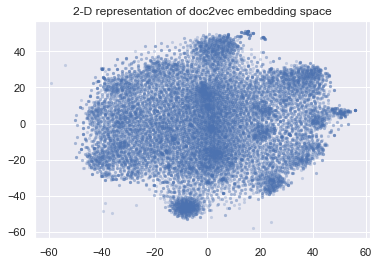

In [97]:
# Visualize learned document embedding space using t-SNE1
from sklearn.manifold import TSNE
import seaborn as sns
plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
# fit and transform the training feature
projection = TSNE().fit_transform(d2v_model_vocab2.dv.vectors)
plt.title("2-D representation of doc2vec embedding space")
plt.scatter(*projection.T, **plot_kwds)